In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx 

### CLR rounds

In [2]:
clr_round9_df = pd.read_csv('https://github.com/gitcoinco/gitcoin_cadcad_model/raw/main/data/2021-03-18/2021-03-18-round9-contributions.csv.xz', compression="xz")


In [3]:
clr_round9_df

time_sequence                        created_on contributor  \
0                  0  2021-03-09 23:59:02.658000-07:00  70b13b328c   
1                  1  2021-03-09 23:59:10.079000-07:00  963ac464f3   
2                  2  2021-03-09 23:59:14.991000-07:00  ccebfd1e60   
3                  3  2021-03-09 23:59:20.639000-07:00  70b13b328c   
4                  4  2021-03-09 23:59:23.956000-07:00  5b7d5b422a   
...              ...                               ...         ...   
80349          80349  2021-03-18 09:35:49.035000-06:00  d0eecbd79d   
80350          80350  2021-03-18 09:35:50.777000-06:00  d0eecbd79d   
80351          80351  2021-03-18 09:36:06.510000-06:00  d0eecbd79d   
80352          80352  2021-03-18 09:36:08.260000-06:00  d0eecbd79d   
80353          80353  2021-03-18 09:36:52.313000-06:00  d0eecbd79d   

                                                   grant    amount  \
0                      Gitcoin Grants Round 9 + Dev Fund  4.957804   
1                                 Zero Knowledge Podcast  0.950000   
2                      Gitcoin Grants Round 9 + Dev Fund  0.250000   
3                      Gitcoin Grants Round 9 + Dev Fund  0.248012   
4                   vfat.tools Yield Farming Calculators  1.770644   
...                                                  ...       ...   
80349                                 Illuminate Finance  0.000000   
80350                  Gitcoin Grants Round 9 + Dev Fund  0.000000   
80351  Getting Started With NFTs - Video Tutorials on...  0.000000   
80352                  Gitcoin Grants Round 9 + Dev Fund  0.000000   
80353  Learning Data Science on the Ethereum Blockcha...  0.000000   

       sybil_score token  amount_in_token  success  flag  
0                1   ETH          0.00280     True     0  
1                0   DAI          1.00000     True     0  
2                1   DAI          0.25000     True     0  
3                1   ETH          0.00014     True     0  
4                2   ETH          0.00100     True     0  
...            ...   ...              ...      ...   ...  
80349            5   ETH          0.00050     True     0  
80350            5   ETH          0.00100     True     0  
80351            0   ETH          0.00100     True     0  
80352            0   ETH          0.00005     True     0  
80353           -1   ETH          0.00800     True     0  

[80354 rows x 10 columns]

In [4]:
clr_round9_df['created_on'] = pd.to_datetime(clr_round9_df['created_on'], utc=True).dt.tz_localize(None)

In [5]:
round9_dict = clr_round9_df.to_dict(orient='index')

In [6]:
round9_dict[1]

{'time_sequence': 1,
 'created_on': Timestamp('2021-03-10 06:59:10.079000'),
 'contributor': '963ac464f3',
 'grant': 'Zero Knowledge Podcast',
 'amount': 0.95,
 'sybil_score': 0,
 'token': 'DAI',
 'amount_in_token': 1.0,
 'success': True,
 'flag': 0}

In [8]:
Gs = []
for k, v in round9_dict.items():
    G = nx.Graph()
    G.add_node(v['contributor'])
    G.nodes[v['contributor']]['type'] = 'contributor'
    G.add_node(v['contributor'], sybil_score = v['sybil_score'])
    G.add_node(v['grant'])
    G.nodes[v['grant']]['type'] = 'grant'
    amnt = v['amount']
    if amnt > 0.0: 
        G.add_edge(v['contributor'],v['grant'], amount=amnt)
    U = nx.Graph()
    if k > 0:
        U = Gs[k-1].copy()
    U.update(G.edges(data=True),G.nodes(data=True))
    Gs.append(U)
    if k == 12000: break

In [10]:
def total_amount(G: nx.Graph,
                 node: str) -> (float, float):
    """
    Get the ration amount/degree 
    for a given node (grant or contributor)
    """
    # Get all the graph edges associated with the node
    node_edges = G.edges([node])
    
    # Sum all amounts contained in the edges that contains the node
    total_amount = sum(G.edges[edge]['amount']
                       for edge
                       in node_edges)
    
    # Return it
    return total_amount

In [11]:
def add_totals(G: nx.Graph) -> nx.Graph:
    """
    Add total_amount from contributions edges from the cadCAD results DataFrame
    into a NetworkX graph.
    """
    contrib_row = list(G.edges().data())
    # Make sure that we have data
    if len(contrib_row) > 0:
        

        
        # Get unique grants and contributors
        l = list(G.nodes().data())
        unique_grants = set([t[0] for t in l if t[1]['type'] == 'grant'])
        unique_contributors = set([t[0] for t in l if t[1]['type'] == 'contributor'])
        
        # Associate the 'type' and 'total_amount' attributes for grants and contributors
        grant_node_type = {el: {'type': 'grant',
                                 'total_amount': total_amount(G, el),
                                'degree': G.degree[el]} 
                           for el in unique_grants}
        contrib_node_type = {el: {'type': 'contributor',
                                   'total_amount': total_amount(G, el),
                                  'degree': G.degree[el]} 
                             for el in unique_contributors}
        node_type = {**grant_node_type, **contrib_node_type}    
        
        nx.set_node_attributes(G, node_type)
        
        # Return the graph
        return G
    else:
        return None

In [12]:
graphs = []
for g in Gs:
    graphs.append(add_totals(g))

In [13]:
list(graphs[1].nodes().data())

[('70b13b328c',
  {'type': 'contributor',
   'sybil_score': 1,
   'total_amount': 4.957804131189699,
   'degree': 1}),
 ('Gitcoin Grants Round 9 + Dev Fund',
  {'type': 'grant', 'total_amount': 4.957804131189699, 'degree': 1}),
 ('963ac464f3',
  {'type': 'contributor',
   'sybil_score': 0,
   'total_amount': 0.95,
   'degree': 1}),
 ('Zero Knowledge Podcast',
  {'type': 'grant', 'total_amount': 0.95, 'degree': 1})]

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
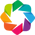

CPU times: user 1.45 s, sys: 367 ms, total: 1.82 s
Wall time: 2.31 s


In [14]:
%%time
import holoviews as hv
import holoviews.plotting.mpl
from holoviews import opts, dim
import panel as pn
hv.extension("bokeh")

In [15]:
import math
import random

number_of_colors = 20
l = list(Gs[len(Gs)-1].nodes().data())
unique_grants = set([t[0] for t in l if t[1]['type'] == 'grant'])
unique_contributors = set([t[0] for t in l if t[1]['type'] == 'contributor'])
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
grants_2_color = {}
contributiors_2_color = {}
for grant in unique_grants:
    grants_2_color[grant] = color[random.randint(0, 19)]
for contributor in unique_contributors:
    contributiors_2_color[contributor] = color[random.randint(0, 19)]

In [44]:
from bokeh.models import HoverTool

In [66]:
def make_points(G: nx.graph, t: str):

    ps = []
    nds = list(G.nodes().data())
    nodes = [n for n in nds if n[1]['type'] == 'grant']
    for node in nodes:
        total_amount = node[1]['total_amount']
        degree = node[1]['degree']
        if degree == 0: degree = 1
        ratio = total_amount/degree
        if t == node[1]['type'] and ratio < 200:
            ps.append([ degree, ratio, grants_2_color[node[0]], total_amount*0.01 ])
    tooltips = [
        ('index', '@index'),
        ('type', '@type')
    ]
    hover = HoverTool(tooltips=tooltips)
    popts = opts.Points(color='z', size=dim('size'),  frame_width=800, frame_height=800, tools=['hover'])

    points = hv.Points(ps, vdims=['z', 'size'])
    points.redim.label(x='Node Degree')
    points.redim.label(y='Ratio total_amount/degree')
    
    points.opts(popts)  
    return points

In [67]:
def hvplot_points_sequence(Gs: list, range1=1000, step=20):
    # TODO add test
    hmap = hv.HoloMap({i:make_points(Gs[i], 'grant') for i in range(1,range1, step)})
    return hmap


In [68]:
hmap2 = hvplot_points_sequence(graphs, 2000, 100)

In [69]:
hmap2

:HoloMap   [Default]
   :Points   [x,y]   (z,size)

In [70]:
hmap = hvplot_points_sequence(graphs, len(graphs), 100)

In [71]:
hmap

:HoloMap   [Default]
   :Points   [x,y]   (z,size)